In [29]:
!pip install numba
!pip install numpy_groupies

In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45379")
client

<Client: 'tcp://127.0.0.1:45379' processes=8 threads=64, memory=235.96 GiB>

In [2]:
client.restart()

<Client: 'tcp://127.0.0.1:40679' processes=7 threads=56, memory=206.47 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from xgcm.grid import Grid
from xhistogram.xarray import histogram as xhist
from scipy.interpolate import griddata
import xwavelet
import gcm_filters
import gsw
import xrft
import s3fs
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import intake
import os
import gcsfs

gcs = gcsfs.GCSFileSystem(requester_pays=True)

SCRATCH = os.environ['SCRATCH_BUCKET']
SCRATCH

'gs://meom-ige-scratch/roxyboy'

In [4]:
# import sys
# sys.path.append("/home/jovyan/MLI_Bodner")
from validate_catalog import all_params
params_dict, cat = all_params()
params_dict.keys()

dict_keys(['GIGATL', 'HYCOM25', 'HYCOM50', 'eNATL60', 'FESOM', 'ORCA36', 'FIO-COM32'])

In [5]:
dss = cat.eNATL60(region='1',datatype='surface_hourly', season='fma'
                 ).to_dask()
dss.coords['day'] = ('time_counter',np.repeat(np.arange(len(dss.time_counter)//24),
                                              24))
dss = dss.groupby('day').mean('time_counter',skipna=True)

dss

<xarray.Dataset>
Dimensions:   (y: 763, x: 611, day: 89)
Coordinates: (12/14)
    depth     (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1t       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1u       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e1v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    e2f       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    ...        ...
    e2v       (y, x) float64 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lat       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    lon       (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lat   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
    nav_lon   (y, x) float32 dask.array<chunksize=(763, 611), meta=np.ndarray>
  * day       (day) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
Dimensions without coordinates: y, x
Data variables: (12/13)
    fmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    qt_oce    (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    somecrty  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sometauy  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sosaline  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sossheig  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    ...        ...
    sowaflup  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozocrtx  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    sozotaux  (day, y, x) float32 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    tmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    umask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>
    vmask     (day, y, x) int8 dask.array<chunksize=(1, 763, 611), meta=np.ndarray>

In [6]:
dsi = cat.eNATL60(region='1',datatype='interior_daily', season='fma'
                 ).to_dask().isel(deptht=slice(None,-1),depthv=slice(None,-1),
                                  depthu=slice(None,-1)
                                 ).chunk({'deptht':5,'depthw':5,
                                          'depthv':5,'depthu':5}
                                        )
dsi

<xarray.Dataset>
Dimensions:       (y: 763, x: 611, deptht: 106, depthu: 106, depthv: 106,
                   depthw: 107, time_counter: 89)
Coordinates: (12/18)
    depth         (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * deptht        (deptht) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthu        (depthu) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthv        (depthv) float32 0.4805 1.559 2.794 ... 951.6 968.4 985.3
  * depthw        (depthw) float32 0.0 1.0 2.157 3.471 ... 960.0 976.9 993.8
    e1f           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    ...            ...
    e2v           (y, x) float64 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lat           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    lon           (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
    nav_lon       (y, x) float32 dask.array<chunksize=(73, 611), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 2010-02-01 ... 2010-04-30
Dimensions without coordinates: y, x
Data variables: (12/13)
    e3t_0         (deptht, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3u_0         (depthu, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3v_0         (depthv, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    e3w_0         (depthw, y, x) float64 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    fmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    tmask         (deptht, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    ...            ...
    vmask         (depthv, y, x) int8 dask.array<chunksize=(5, 73, 611), meta=np.ndarray>
    vomecrty      (time_counter, depthv, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vosaline      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vovecrtz      (time_counter, depthw, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>
    vozocrtx      (time_counter, depthu, y, x) float32 dask.array<chunksize=(3, 5, 73, 611), meta=np.ndarray>

In [7]:
YC = dss.lat.mean('x')
XC = dss.lon.mean('y')
YG = xr.concat([YC[0]-YC.diff('y').min(skipna=True),
                .5*(YC[1:] + YC[:-1])
               ],'y')
XG = xr.concat([XC[0]-XC.diff('x').min(skipna=True),
                .5*(XC[1:] + XC[:-1])
               ],'x')

In [8]:
taux = xr.DataArray(dss.sozotaux.data, dims=['time','YC','XG'],
                    coords={'YC':YC.data,'XG':XG.data}
                   )
tauy = xr.DataArray(dss.sometauy.data, dims=['time','YG','XC'],
                    coords={'YG':YG.data,'XC':XC.data}
                   )
fwf  = xr.DataArray(dss.sowaflup.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )
Q    = xr.DataArray(dss.qt_oce.data, dims=['time','YC','XC'],
                    coords={'YC':YC.data,'XC':XC.data}
                   )

In [8]:
# v  = xr.DataArray(dsi.vomecrty.data, dims=['time','Z','YG','XC'],
#                   coords={'Z':dsi.depthv.data,'YG':YG.data,'XC':XC.data}
#                  )
# u  = xr.DataArray(dsi.vozocrtx, dims=['time','Z','YC','XG'],
#                   coords={'Z':dsi.depthu.data,'YC':YC.data,'XG':XG.data}
#                  )
w  = xr.DataArray(dsi.vovecrtz.data, dims=['time','Zp1','YC','XC'],
                  coords={'Zp1':dsi.depthw.data,'YC':YC.data,'XC':XC.data}
                 )
CT = xr.DataArray(dsi.votemper.data, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )
SA = xr.DataArray(dsi.vosaline, dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,'YC':YC.data,'XC':XC.data}
                 )

In [9]:
ds = CT.to_dataset(name='CT')
ds['SA'] = SA
# ds['U'] = u
# ds['V'] = v
ds['W'] = w
# ds['taux'] = taux  # N/m2 = (kg.m/s2)/m2
# ds['tauy'] = tauy  # N/m2
# ds['Ffw'] = fwf    # kg/m2/s
# ds['Q'] = Q        # W/m2 = (N.m/s)/m2 = (kg.m2/s3)/m2
ds.coords['maskC'] = xr.DataArray(dsi.tmask.data, dims=['Z','YC','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XC':XC.data}
                          )
ds.coords['maskW'] = xr.DataArray(dsi.umask.data, dims=['Z','YC','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YC':YC.data,'XG':XG.data}
                          )
ds.coords['maskS'] = xr.DataArray(dsi.vmask.data, dims=['Z','YG','XC'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XC':XC.data}
                          )
ds.coords['maskG'] = xr.DataArray(dsi.fmask.data, dims=['Z','YG','XG'],
                           coords={'Z':dsi.deptht.data,
                                   'YG':YG.data,'XG':XG.data}
                          )
ds.coords['DXU'] = xr.DataArray(dss.e1u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DYU'] = xr.DataArray(dss.e2u.data,
                   dims=['YC','XG'], 
                   coords={'YC':YC.data,'XG':XG.data}
                  )
ds.coords['DXV'] = xr.DataArray(dss.e1v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DYV'] = xr.DataArray(dss.e2v.data,
                   dims=['YG','XC'], 
                   coords={'YG':YG.data,'XC':XC.data}
                  )
ds.coords['DXT'] = xr.DataArray(dss.e1t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DYT'] = xr.DataArray(dss.e2t.data,
                   dims=['YC','XC'], 
                   coords={'YC':YC.data,'XC':XC.data}
                  )
ds.coords['DXF'] = xr.DataArray(dss.e1f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )
ds.coords['DYF'] = xr.DataArray(dss.e2f.data,
                   dims=['YG','XG'], 
                   coords={'YG':YG.data,'XG':XG.data}
                  )

coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        "Z": {"center": "Z",  "outer":"Zp1"}
       }
grid = Grid(ds, periodic=[],
            coords=coords
           )
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center
Z Axis (not periodic, boundary=None):
  * center   Z --> outer
  * outer    Zp1 --> center

In [33]:
tskp = 10; kskp = 3

In [11]:
area = (dss.e1t * dss.e2t)

dxw = xr.DataArray(dss.e1u.data, dims=['y','x'],
                   coords={'y':np.arange(len(dss.y)),
                           'x':np.arange(len(dss.x))}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['y','x'],
                   coords={'y':np.arange(len(dss.y)),
                           'x':np.arange(len(dss.x))}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['y','x'],
                   coords={'y':np.arange(len(dss.y)),
                           'x':np.arange(len(dss.x))}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['y','x'],
                   coords={'y':np.arange(len(dss.y)),
                           'x':np.arange(len(dss.x))}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.DataArray(np.zeros_like(dsi.votemper.isel(time_counter=0)),
                        dims=['deptht','y','x'],
                        coords={'deptht':dsi.deptht,
                                'y':np.arange(len(dss.y)),
                                'x':np.arange(len(dss.x))}
           )
wet_mask[:,1:-1,1:-1] = dsi.tmask[:,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask)
kappa_w[:,1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[:,1:-1,1:-1] += 1.


filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask[::kskp].chunk({'y':-1,'x':-1}), 
        'dxw': dxw.chunk({'y':-1,'x':-1}), 'dyw': dyw.chunk({'y':-1,'x':-1}), 
        'dxs': dxs.chunk({'y':-1,'x':-1}), 'dys': dys.chunk({'y':-1,'x':-1}), 
        'area': area.chunk({'y':-1,'x':-1}), 
        'kappa_w': kappa_w[::kskp].chunk({'y':-1,'x':-1}), 
        'kappa_s': kappa_s[::kskp].chunk({'y':-1,'x':-1})
    }
)

In [12]:
grav = 9.81
w_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0


b = -xr.DataArray(sig0w.where(dsi.tmask!=0.)[::tskp,::kskp].data,
                  dims=['time_counter','deptht','y','x'],
                  coords={'time_counter':dsi.time_counter.data[::tskp], 
                          'deptht':dsi.deptht[::kskp],
                          'y':np.arange(len(dsi.y)),
                          'x':np.arange(len(dsi.x))}
                 ).chunk({'deptht':5}) * grav / 1e3

w = xr.DataArray(.5*(dsi.vovecrtz.isel(depthw=slice(1,None)
                                      ).fillna(0.)[::tskp,::kskp].data 
                     + dsi.vovecrtz.isel(depthw=slice(None,-1)
                                        ).fillna(0.)[::tskp,::kskp].data
                    ),
                 dims=['time_counter','deptht','y','x'],
                 coords={'time_counter':dsi.time_counter.data[::tskp], 
                         'deptht':dsi.deptht[::kskp],
                         'y':np.arange(len(dsi.y)),
                         'x':np.arange(len(dsi.x))}
                ).chunk({'deptht':5})

/tmp/ipykernel_1731/3930723714.py:3: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sig0w = xr.open_zarr(gcs.get_mapper(w_path)).sig0
/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/indexing.py:1228: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.confi

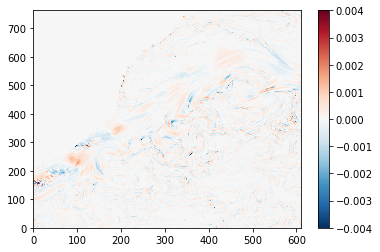

In [37]:
plt.pcolormesh((.5*(dsi.vovecrtz.isel(depthw=slice(1,None)
                                      ).fillna(0.)[::tskp,::kskp].data 
                     + dsi.vovecrtz.isel(depthw=slice(None,-1)
                                        ).fillna(0.)[::tskp,::kskp].data
                    ))[0,10], 
               cmap='RdBu_r', vmax=.004, vmin=-.004)
plt.colorbar()

In [13]:
wm = filter_30km.apply(w.chunk({'y':-1,'x':-1}), 
                       dims=['y', 'x']
                      ).isel(y=slice(1,-1),x=slice(1,-1)
                            ).reset_coords(drop=True).compute().chunk({'time_counter':1,
                                                                       'deptht':5})
bm = filter_30km.apply(b.chunk({'y':-1,'x':-1}), 
                       dims=['y', 'x']
                      ).isel(y=slice(1,-1),x=slice(1,-1)
                            ).reset_coords(drop=True).compute().chunk({'time_counter':1,
                                                                       'deptht':5})
ws = (w.isel(y=slice(1,-1),x=slice(1,-1)) 
      - wm).reset_coords(drop=True)
bs = (b.isel(y=slice(1,-1),x=slice(1,-1)) 
      - bm).reset_coords(drop=True)
ws

,Array,Chunk
Bytes,1.12 GiB,1.70 MiB
Shape,"(9, 36, 761, 609)","(1, 5, 73, 609)"
Count,95575 Tasks,792 Chunks
Type,float64,numpy.ndarray


# Interpolate to monotonic metric grid

In [14]:
XT = grid.cumsum(ds.DXU,'X',boundary='extend'
                ).isel(YC=slice(1,-1),XC=slice(1,-1))
YT = grid.cumsum(ds.DYV,'Y',boundary='extend'
                ).isel(YC=slice(1,-1),XC=slice(1,-1))
ny,nx = XT.shape
xT = (XT - XT.isel(XC=nx//2)).values.flatten()
yT = (YT - YT.isel(YC=ny//2)).values.flatten()
dx = ds.DXT.isel(YC=slice(1,-1),XC=slice(1,-1)).min().values
dy = ds.DYT.isel(YC=slice(1,-1),XC=slice(1,-1)).min().values
yy = np.arange(-ny*dy/2,ny*dy/2,dy) 
xx = np.arange(-nx*dx/2,nx*dx/2,dx)

Wmterp = xr.DataArray(np.zeros_like(wm), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Bmterp = xr.DataArray(np.zeros_like(bm), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Wsterp = xr.DataArray(np.zeros_like(ws), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Bsterp = xr.DataArray(np.zeros_like(bs), dims=['time','Z','YC','XC'],
                      coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                     )
Aterp = xr.DataArray(np.zeros_like(area.isel(y=slice(1,-1),x=slice(1,-1))), 
                     dims=['YC','XC'],
                     coords={'YC':yy,'XC':xx}
                    )

In [15]:
xxx, yyy = np.mgrid[-nx*dx/2:nx*dx/2:dx, -ny*dy/2:ny*dy/2:dy]
Aterp = griddata((xT, yT), 
                 area.isel(y=slice(1,-1),x=slice(1,-1)).values.flatten(),
                 (xxx, yyy) 
                ).T
Aterp

array([[2464369.40602636, 2464391.17141636, 2464416.58051592, ...,
        2481349.28794967, 2481366.18716382, 2481401.37181008],
       [2463604.96861839, 2463624.99365636, 2463650.26095829, ...,
        2480634.59830504, 2480651.01547964, 2480687.42783415],
       [2462839.95255576, 2462858.06661095, 2462882.89697054, ...,
        2479932.98268839, 2479950.74865585, 2479987.42778067],
       ...,
       [1851161.62821289, 1851246.17671487, 1851333.16522447, ...,
        1915965.65564556, 1916094.05925207, 1916247.24386313],
       [1850326.7011259 , 1850410.75482252, 1850497.23158512, ...,
        1915175.55145422, 1915309.83003223, 1915469.60014244],
       [1849489.24966915, 1849571.23386891, 1849655.77994983, ...,
        1914399.80181858, 1914538.72204875, 1914702.16138098]])

In [16]:
for tt in range(len(ds.time[::tskp])):
    for zz in range(len(ds.Z[::kskp])):
        Wmterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (wm * area.isel(y=slice(1,-1),x=slice(1,-1))
                                              ).isel(time_counter=tt,deptht=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Bmterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (bm * area.isel(y=slice(1,-1),x=slice(1,-1))
                                              ).isel(time_counter=tt,deptht=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Wsterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (ws * area.isel(y=slice(1,-1),x=slice(1,-1))
                                              ).isel(time_counter=tt,deptht=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        Bsterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                              (bs * area.isel(y=slice(1,-1),x=slice(1,-1))
                                              ).isel(time_counter=tt,deptht=zz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
    print(tt)
                        
Wmterp = (Wmterp / Aterp).chunk({'time':1,'Z':1})
Wsterp = (Wsterp / Aterp).chunk({'time':1,'Z':1})
Bmterp = (Bmterp / Aterp).chunk({'time':1,'Z':1})
Bsterp = (Bsterp / Aterp).chunk({'time':1,'Z':1})

0
1
2
3
4
5
6
7
8


In [18]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'Wm_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Wmterp.to_dataset(name='Wm').to_zarr(store_tmp, mode='w')
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'Ws_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Wsterp.to_dataset(name='Ws').to_zarr(store_tmp, mode='w')
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'Bm_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Bmterp.to_dataset(name='Bm').to_zarr(store_tmp, mode='w')
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'Bs_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Bsterp.to_dataset(name='Bs').to_zarr(store_tmp, mode='w')

In [19]:
Wterp = xr.DataArray(np.zeros_like(w.isel(y=slice(1,-1),x=slice(1,-1))), 
                     dims=['time','Z','YC','XC'],
                     coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                    )
Bterp = xr.DataArray(np.zeros_like(b.isel(y=slice(1,-1),x=slice(1,-1))), 
                     dims=['time','Z','YC','XC'],
                     coords={'Z':ds.Z[::kskp],'YC':yy,'XC':xx}
                    )

for tt in range(len(ds.time[::tskp])):
    for zz in range(len(ds.Z[::kskp])):
        Wterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                             (w * area
                                             ).isel(time_counter=tt,deptht=zz,
                                                    y=slice(1,-1),x=slice(1,-1)
                                                   ).values.flatten(),
                                             (xxx, yyy) 
                                            ).T 
        Bterp[dict(time=tt,Z=zz)] = griddata((xT, yT), 
                                             (b * area
                                             ).isel(time_counter=tt,deptht=zz,
                                                    y=slice(1,-1),x=slice(1,-1)
                                                   ).values.flatten(),
                                             (xxx, yyy) 
                                            ).T 
    print(tt)

Wterp = (Wterp / Aterp).chunk({'time':1,'Z':1})
Bterp = (Bterp / Aterp).chunk({'time':1,'Z':1})

0
1
2
3
4
5
6
7
8


In [20]:
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'W_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Wterp.to_dataset(name='W').to_zarr(store_tmp, mode='w')
tmp_path = f'{SCRATCH}/region01/eNATL60/'+f'B_interpolated_fma.zarr'
store_tmp = gcs.get_mapper(tmp_path)
Bterp.to_dataset(name='B').to_zarr(store_tmp, mode='w')

In [23]:
xrft.isotropic_power_spectrum(w, dim=['YC','XC'], 
                              window='hann', window_correction=True, 
                              nfactor=8, truncate=True
                             )

,Array,Chunk
Bytes,129.09 kiB,408 B
Shape,"(9, 36, 51)","(1, 1, 51)"
Count,7793 Tasks,324 Chunks
Type,float64,numpy.ndarray


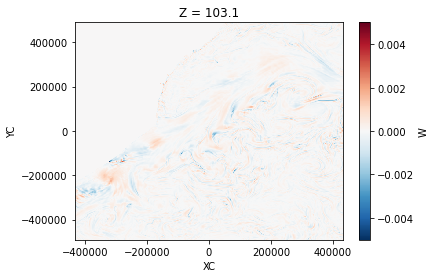

In [30]:
w.isel(time=0,Z=10).plot()

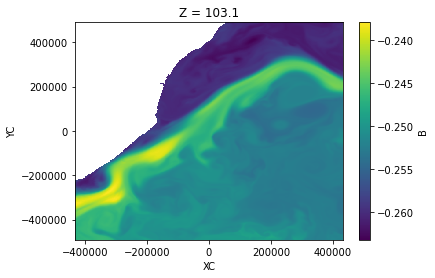

In [31]:
b.isel(time=0,Z=10).plot()

In [28]:
d_path = f'{SCRATCH}/region01/eNATL60/'+f'W_interpolated_fma.zarr'
w = xr.open_zarr(gcs.get_mapper(d_path)).W
d_path = f'{SCRATCH}/region01/eNATL60/'+f'B_interpolated_fma.zarr'
b = xr.open_zarr(gcs.get_mapper(d_path)).B
Fwb = xrft.cross_spectrum(w.fillna(0.), b.fillna(0.), dim=['YC','XC'], 
                          window='hann', window_correction=True, 
                          true_phase=True,
                         )
Fwb = xrft.isotropize(Fwb, ['freq_YC','freq_XC'], 
                      nfactor=8, truncate=True
                     )
Fwb

TypingError: [1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1m[1mFailed in nopython mode pipeline (step: nopython frontend)
[1m[1mNo implementation of function Function(<built-in function setitem>) found for signature:
 
 >>> setitem(array(float64, 1d, C), int64, complex128)
 
There are 16 candidate implementations:
[1m  - Of which 16 did not match due to:
  Overload of function 'setitem': File: <numerous>: Line N/A.
    With argument(s): '(array(float64, 1d, C), int64, complex128)':[0m
[1m   No match.[0m
[0m
[0m[1mDuring: typing of setitem at /srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py (416)[0m
[1m
File "../../srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py", line 416:[0m
[1m    def _inner(ri, val, ret, counter, mean, fill_value):
        <source elided>
        counter[ri] += 1
[1m        ret[ri] += val
[0m        [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function Mean._inner at 0x7f603c4c53f0>))[0m
[0m[1mDuring: typing of call at /srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py (130)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function Mean._inner at 0x7f603c4c53f0>))[0m
[0m[1mDuring: typing of call at /srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py (130)
[0m
[1m
File "../../srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py", line 130:[0m
[1m        def loop(group_idx, a, ret, counter, mean, outer, fill_value, ddof):
            <source elided>
                val = valgetter(a, i)
[1m                inner(ri, val, ret, counter, mean, fill_value)
[0m                [1m^[0m[0m

[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function AggregateOp.callable.<locals>.loop at 0x7f601c9e37f0>))[0m
[0m[1mDuring: typing of call at /srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py (176)
[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function AggregateOp.callable.<locals>.loop at 0x7f601c9e37f0>))[0m
[0m[1mDuring: typing of call at /srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py (176)
[0m
[1m
File "../../srv/conda/envs/notebook/lib/python3.10/site-packages/numpy_groupies/aggregate_numba.py", line 176:[0m
[1m        def loop_2pass(group_idx, a, ret, counter, mean, outer, fill_value, ddof):
[1m            loop_1st(group_idx, a, ret, counter, mean, outer, fill_value, ddof)
[0m            [1m^[0m[0m
[0m

In [18]:
xo = 50e3
s = xr.DataArray(Fwb.freq_r.data**-1 / xo, dims='scale',
                 coords={'scale':Fwbfreq_r.data**-1 / xo})
print(s)
Wwb = xwavelet.wvlt_cross_spectrum(w.chunk({'YC':100,'XC':100}), 
                                   b.chunk({'YC':100,'XC':100}), 
                                   s, dim=['YC','XC']
                            )
Wwb

<xarray.DataArray (scale: 51)>
array([4.41871094, 1.87401319, 1.14889959, 0.82687866, 0.64435467,
       0.5275423 , 0.44646918, 0.38705651, 0.34167074, 0.30571242,
       0.27655977, 0.25255442, 0.23242932, 0.21519027, 0.20032494,
       0.187442  , 0.17609758, 0.16601968, 0.15705222, 0.14901543,
       0.14177292, 0.13518455, 0.12916216, 0.12366009, 0.11861932,
       0.11397018, 0.10965993, 0.10566693, 0.10196404, 0.09850795,
       0.09527647, 0.09225221, 0.08941601, 0.08674948, 0.08423435,
       0.08185901, 0.07961599, 0.07749537, 0.07548407, 0.07357212,
       0.07175956, 0.07003516, 0.06838322, 0.0668082 , 0.0653082 ,
       0.06387356, 0.06249906, 0.06118217, 0.05992106, 0.05871073,
       0.05754792])
Coordinates:
  * scale    (scale) float64 4.419 1.874 1.149 ... 0.05992 0.05871 0.05755


,Array,Chunk
Bytes,1.01 MiB,3.19 kiB
Shape,"(9, 36, 8, 51)","(1, 1, 8, 51)"
Count,307959 Tasks,324 Chunks
Type,float64,numpy.ndarray


In [19]:
dtheta = np.pi/len(wb.angle)
Wwb_int = Wwb.sum('angle').mean('time').compute() * dtheta

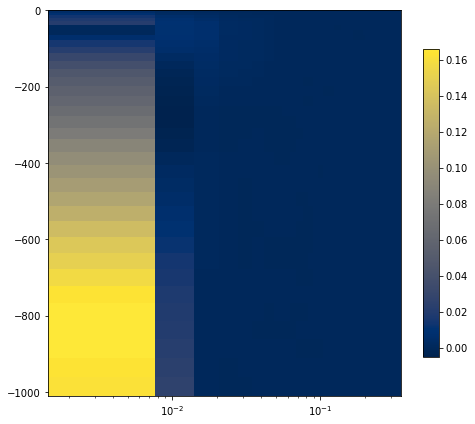

In [21]:
fig, ax = plt.subplots(figsize=(7,6))
fig.set_tight_layout(True)
im = ax.pcolormesh(wb_int.scale**-1*1e3, -wb_int.Z, wb_int, cmap='cividis')
ax.set_xscale('log')
fig.colorbar(im, ax=ax, shrink=.8)

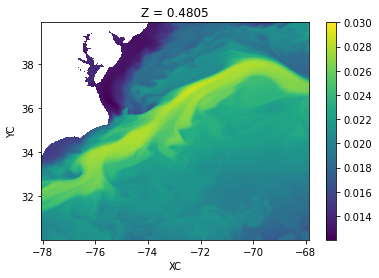

In [ ]:
wstar = (-B0/hE)**(1/3)
wstar.isel(time=0).plot(vmax=.03)

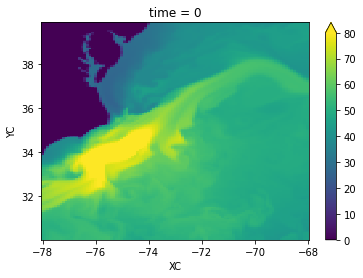

In [ ]:
Cl = .25
mstar = .5
nstar = .066

Lf = Cl*(mstar*ustar**3 + nstar*wstar**3)**(2/3) / f**2 / hE

Lfb = xr.DataArray((Lf*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
(Lfb).isel(time=0).plot(vmax=80)

In [ ]:
w_path = f'{SCRATCH}/region01/eNATL60/'+f'sigma0_fma.zarr'
sig0 = xr.open_zarr(gcs.get_mapper(w_path)).sig0

rho0 = 1e3
b = -xr.DataArray(sig0.isel(deptht=slice(None,-1)).data,
                  dims=['time','Z','YC','XC'],
                  coords={'Z':dsi.deptht.data,
                          'YC':YC.data,
                          'XC':XC.data}
                 ).chunk({'Z':5}).where(ds.maskC!=0.) * grav / rho0

/tmp/ipykernel_1340/623756957.py:2: RuntimeWarning: Failed to open Zarr store with consolidated metadata, falling back to try reading non-consolidated metadata. This is typically much slower for opening a dataset. To silence this warning, consider:
1. Consolidating metadata in this existing store with zarr.consolidate_metadata().
2. Explicitly setting consolidated=False, to avoid trying to read consolidate metadata, or
3. Explicitly setting consolidated=True, to raise an error in this case instead of falling back to try reading non-consolidated metadata.
  sig0 = xr.open_zarr(gcs.get_mapper(w_path)).sig0


In [ ]:
B = ((b.where(b.Z<=np.abs(H)) 
      * dsi.e3t_0.data[np.newaxis]).sum('Z',skipna=True) 
      / np.abs(H)
    )
W = ((ds.W.where(grid.interp(ds.maskC.chunk({'Z':-1}),'Z',boundary='extend')!=0.
                ).where(ds.Zp1<=np.abs(H)) 
      * dsi.e3w_0.data[np.newaxis]).sum('Zp1',skipna=True) 
      / np.abs(H)
    )
WB = ((grid.interp(ds.W.chunk({'Zp1':-1}),'Z',boundary='extend')
       * b.where(b.Z<=np.abs(H)) 
       * dsi.e3t_0.data[np.newaxis]).sum('Z',skipna=True) 
      / np.abs(H)
     )
WB

,Array,Chunk
Bytes,316.55 MiB,273.75 kiB
Shape,"(89, 763, 611)","(3, 73, 160)"
Count,528776 Tasks,1680 Chunks
Type,float64,numpy.ndarray


# Reynold's decomposition
## $$ \overline{w'b'}^z = \overline{wb}^z - \overline{w}^z\overline{b}^z $$

In [ ]:
Bb = xr.DataArray((B*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
Wb = xr.DataArray((W*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
WBb = xr.DataArray((WB*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
       / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
      )
wbb = WBb - Wb*Bb
WBb

,Array,Chunk
Bytes,8.71 MiB,7.59 kiB
Shape,"(89, 127, 101)","(3, 12, 27)"
Count,550134 Tasks,1680 Chunks
Type,float64,numpy.ndarray


In [ ]:
dxu = xr.DataArray(dss.e1u.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dyu = xr.DataArray(dss.e2u.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XG'], 
                   coords={'YC':yC,'XG':xG}
                  )
dxv = xr.DataArray(dss.e1v.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dyv = xr.DataArray(dss.e2v.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XC'], 
                   coords={'YG':yG,'XC':xC}
                  )
dxt = xr.DataArray(dss.e1t.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dyt = xr.DataArray(dss.e2t.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YC','XC'], 
                   coords={'YC':yC,'XC':xC}
                  )
dxf = xr.DataArray(dss.e1f.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )
dyf = xr.DataArray(dss.e2f.coarsen({'y':nC,'x':nC},
                                   boundary='trim').sum(skipna=True),
                   dims=['YG','XG'], 
                   coords={'YG':yG,'XG':xG}
                  )

In [ ]:
dsC = Bb.to_dataset(name='BUOY')
# dsC['WVEL'] = Wb
dsC['wb'] = wbb
dsC.coords['YG'] = yG
dsC.coords['XG'] = xG
dsC.coords['DXU'] = dxu
dsC.coords['DYV'] = dyv
dsC.coords['DXV'] = dxv
dsC.coords['DYU'] = dyu
dsC.coords['DXT'] = dxt
dsC.coords['DYT'] = dyt
dsC.coords['DXF'] = dxf
dsC.coords['DYF'] = dyf
dsC

<xarray.Dataset>
Dimensions:  (time: 89, YC: 127, XC: 101, YG: 127, XG: 101)
Coordinates: (12/13)
  * time     (time) int64 0 1 2 3 4 5 6 7 8 9 ... 79 80 81 82 83 84 85 86 87 88
  * YC       (YC) float32 30.05 30.13 30.21 30.3 ... 39.63 39.7 39.77 39.84
  * XC       (XC) float32 -78.02 -77.92 -77.82 -77.72 ... -68.22 -68.12 -68.02
  * YG       (YG) float32 30.04 30.12 30.21 30.29 ... 39.63 39.7 39.77 39.84
  * XG       (XG) float32 -78.03 -77.92 -77.82 -77.72 ... -68.23 -68.13 -68.03
    DXU      (YC, XG) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    ...       ...
    DXV      (YG, XC) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    DYU      (YC, XG) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    DXT      (YC, XC) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    DYT      (YC, XC) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    DXF      (YG, XG) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
    DYF      (YG, XG) float64 dask.array<chunksize=(127, 101), meta=np.ndarray>
Data variables:
    BUOY     (time, YC, XC) float64 dask.array<chunksize=(3, 12, 26), meta=np.ndarray>
    wb       (time, YC, XC) float64 dask.array<chunksize=(3, 12, 26), meta=np.ndarray>

In [25]:
coords={
        "X": {"center": "XC", "left": "XG"},
        "Y": {"center": "YC", "left": "YG"},
        # "Z": {"center": "Z",  "outer":"Zp1"}
       }
gridC = Grid(dsC, periodic=[],
             coords=coords)
gridC

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   XC --> left
  * left     XG --> center
Y Axis (not periodic, boundary=None):
  * center   YC --> left
  * left     YG --> center

In [29]:
B_x = gridC.interp(gridC.diff(dsC.BUOY,'X',boundary='extend') 
                  / dsC.DXU,
                  'X',boundary='extend')
B_y = gridC.interp(gridC.diff(dsC.BUOY,'Y',boundary='extend') 
                  / dsC.DYV,
                  'Y',boundary='extend')

In [95]:
dxw = xr.DataArray(dss.e1u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at western cell edge

dyw = xr.DataArray(dss.e2u.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at western cell edge

dxs = xr.DataArray(dss.e1v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # x-spacing centered at southern cell edge

dys = xr.DataArray(dss.e2v.data, dims=['YC','XC'],
                   coords={'YC':YC.data,
                           'XC':XC.data}
                  ) # y-spacing centered at southern cell edge

dx_min = min(dss.e1u.min(['y','x']), dss.e2u.min(['y','x']),
             dss.e1v.min(['y','x']), dss.e2v.min(['y','x'])
            )
dx_min = dx_min.values

wet_mask = xr.DataArray(np.zeros_like(dss.sosstsst.isel(day=0)),
                        dims=['YC','XC'],
                        coords={'YC':YC.data,
                                'XC':XC.data}
           )
wet_mask[1:-1,1:-1] = dsi.tmask[0,1:-1,1:-1].data.astype(np.float64)

kappa_w = xr.zeros_like(wet_mask)
kappa_w[1:-1,1:-1] += 1.
kappa_s = xr.zeros_like(wet_mask)
kappa_s[1:-1,1:-1] += 1.

filter_30km = gcm_filters.Filter(
    filter_scale=3e4,   # 30 km
    dx_min=dx_min,
#     n_steps=36,
    filter_shape=gcm_filters.FilterShape.GAUSSIAN,
    grid_type=gcm_filters.GridType.IRREGULAR_WITH_LAND,
    grid_vars={
        'wet_mask': wet_mask.chunk({'YC':-1,'XC':-1}), 
        'dxw': dxw.chunk({'YC':-1,'XC':-1}), 'dyw': dyw.chunk({'YC':-1,'XC':-1}), 
        'dxs': dxs.chunk({'YC':-1,'XC':-1}), 'dys': dys.chunk({'YC':-1,'XC':-1}), 
        'area': area.chunk({'YC':-1,'XC':-1}), 
        'kappa_w': kappa_w.chunk({'YC':-1,'XC':-1}), 
        'kappa_s': kappa_s.chunk({'YC':-1,'XC':-1})
    }
)

In [96]:
Bm = filter_30km.apply(B.chunk({'YC':-1,'XC':-1}), dims=['YC','XC'])

In [97]:
B_x = grid.interp(grid.diff(Bm,'X',boundary='extend') 
                  / dss.e1u.data[np.newaxis],
                  'X',boundary='extend')
B_y = grid.interp(grid.diff(Bm,'Y',boundary='extend') 
                  / dss.e2v.data[np.newaxis],
                  'Y',boundary='extend')

In [47]:
Hb = xr.DataArray((H*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['time','YC','XC'], 
                  coords={'time':ds.time,'YC':yC,'XC':xC}
     )
Db = xr.DataArray((dss.depth.data*area).coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True)
      / area.coarsen({'YC':nC,'XC':nC},boundary='trim').sum(skipna=True),
                  dims=['YC','XC'], 
                  coords={'YC':yC,'XC':xC}
     )

Psix = Lfb/fb * Hb**2 * B_y
Psiy = Lfb/fb * Hb**2 * (-B_x)
Psix

,Array,Chunk
Bytes,8.71 MiB,2.53 kiB
Shape,"(89, 127, 101)","(1, 12, 27)"
Count,561953 Tasks,4984 Chunks
Type,float64,numpy.ndarray


In [36]:
bff = Psix*B_y - Psiy*B_x
bff

,Array,Chunk
Bytes,8.71 MiB,2.53 kiB
Shape,"(89, 127, 101)","(1, 12, 27)"
Count,628827 Tasks,4984 Chunks
Type,float64,numpy.ndarray


Text(0.5, 1.0, '$\\overline{w}^{zyx}\\overline{b}^{zyx}$')

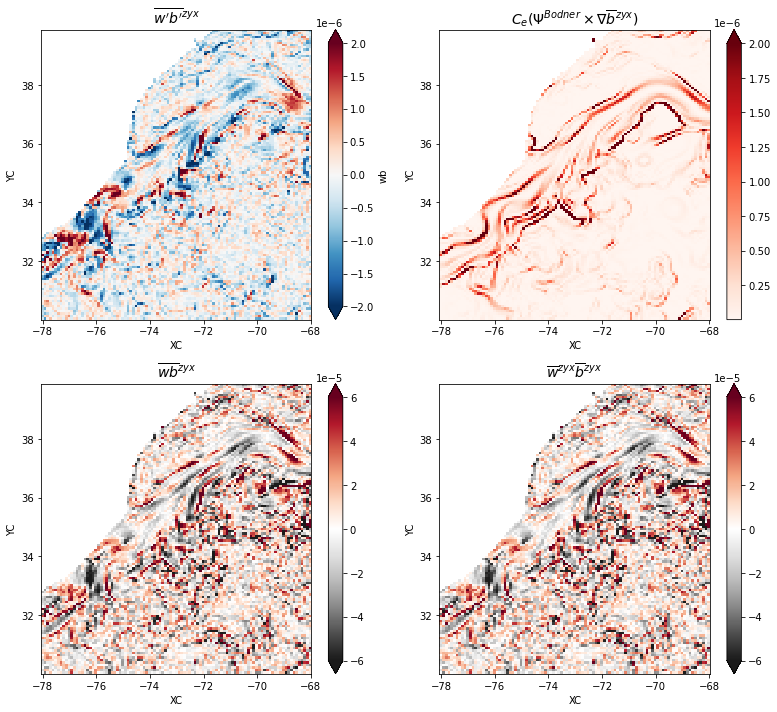

In [57]:
Ce = .06

fig, axes = plt.subplots(figsize=(11,10), nrows=2, ncols=2)
fig.set_tight_layout(True)

dsC.wb.where(Db>200.).isel(time=0).plot(ax=axes[0,0], vmax=2e-6, cmap='RdBu_r', rasterized=True)
(Ce*bff).where(Db>200.).isel(time=0).plot(ax=axes[0,1], vmax=2e-6, cmap='Reds', rasterized=True)
WBb.where(Db>200.).isel(time=0).plot(ax=axes[1,0], vmax=6e-5, cmap='RdGy_r', rasterized=True)
(Wb*Bb).where(Db>200.).isel(time=0).plot(ax=axes[1,1], vmax=6e-5, cmap='RdGy_r', rasterized=True)

axes[0,0].set_title(r"$\overline{w'b'}^{zyx}$", fontsize=14)
axes[0,1].set_title(r"$C_e(\Psi^{Bodner}\times\nabla\overline{b}^{zyx})$", fontsize=14)
axes[1,0].set_title(r"$\overline{wb}^{zyx}$", fontsize=14)
axes[1,1].set_title(r"$\overline{w}^{zyx}\overline{b}^{zyx}$", fontsize=14)

# Filter and coarsen